In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
display(HTML("<style>.container {width:100% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: roicat


In [2]:
from pathlib import Path
import copy
import functools
import gc

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import natsort
import sklearn
import torch


In [3]:
%load_ext autoreload
%autoreload 2
import bnpm

In [4]:
dir_dFoF = r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_aligned/'

dates_toExclude = [
    '20230507',
    '20230515',
]

In [ ]:
dir_tca = r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/ws_and_tca__idx_SI/'

In [6]:
paths_dFoF = bnpm.path_helpers.find_paths(
    dir_outer=dir_dFoF,
    reMatch='dFoF_aligned .*npy',
    depth=4,
    natsorted=True,
)

In [7]:
paths_dFoF

['/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_aligned/20230424/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_aligned/20230425/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_aligned/20230426/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_aligned/20230427/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_aligned/20230428/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_aligned/20230429/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_aligned/20230430/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_aligned/20230501/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_aligned/20230502/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_aligned/20230503/dFoF_align

In [8]:
dates_dFoF = [Path(p).parts[-2] for p in paths_dFoF]

In [9]:
# display(dates)
# display(paths_dFoF)

In [10]:
dFoFs = {d: np.load(p, mmap_mode='r') for d, p in zip(dates_dFoF, paths_dFoF)}

In [11]:
for date in dates_toExclude:
    try:
        dFoFs.pop(date)
    except:
        print(f'failed to exclude date: {date}')

In [12]:
paths_tca = bnpm.path_helpers.find_paths(
    dir_outer=dir_tca,
    reMatch='tca.*npy',
    depth=4,
    natsorted=True,
)

dates_tca = [Path(p).parts[-2] for p in paths_tca]

In [13]:
tcas = {d: np.load(p, mmap_mode='r') for d, p in zip(dates_tca, paths_tca)}

In [14]:
def prep_array_for_regression(arr, mean_sub=False, std_div=False, device='cpu'):
    out = torch.as_tensor(arr, dtype=torch.float32, device=device)
    if mean_sub:
        out = out - torch.nanmean(out, dim=1, keepdim=True)
    out = torch.nan_to_num(out, nan=0.0)
    if std_div:
        out = out / out.std(1, keepdim=True)
    return out

In [15]:
DEVICE_regression = bnpm.torch_helpers.set_device(use_GPU=True)

dfof = prep_array_for_regression(dFoFs['20230509'], mean_sub=True, std_div=False, device=DEVICE_regression)
tca  = prep_array_for_regression(tcas['20230509'], mean_sub=True, std_div=True, device=DEVICE_regression)


devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


/tmp/ipykernel_1710668/411703970.py:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  out = torch.as_tensor(arr, dtype=torch.float32, device=device)


In [16]:
cv = sklearn.model_selection.GroupShuffleSplit(n_splits=1, test_size=0.3)
cv.split = functools.partial(cv.split, groups=bnpm.cross_validation.make_groups(n_samples=dfof.T.shape[0], group_size=30*60*2))

In [17]:
automodel_partial = functools.partial(
    bnpm.automatic_regression.Auto_RidgeRegression,
    params_RidgeRegression={
#         'alpha': [1e-1, 1e6],
        'alpha': 10**3.5,
        'fit_intercept': False,
#         'max_iter': 1000,
#         'tol': 0.0001,
#         'solver': 'cholesky',
#         'positive': False,
    },
    n_startup=36*1,
    kwargs_convergence={
        'n_patience': 36*1,
        'tol_frac': 0.01,
#         'max_trials': 100,
        'max_trials': 1,
        'max_duration': 60*10,
    }, 
#     n_repeats=100,
    n_repeats=1,
    fn_reduce_repeats=torch.median,
    n_jobs_optuna=1,
    penalty_testTrainRatio=1e0,
    test_size=0.3,
    cv=cv,
    verbose=False,
    use_rich_method=True,
)

In [139]:
DEVICE_regression = bnpm.torch_helpers.set_device(use_GPU=True)

n_splits = 100

# automodels = {}
models = {}
alphas = {}
evrs_date = {}
for date in tqdm(tcas.keys()):
    if date not in dFoFs:
        continue
        
    dfof = prep_array_for_regression(dFoFs[date], mean_sub=True, std_div=False, device=DEVICE_regression)
    tca  = prep_array_for_regression(tcas[date], mean_sub=True, std_div=True, device=DEVICE_regression)
    
    alphas[date] = []
#     automodels[date] = []
    models[date] = []
    for i_tca, t in enumerate(tca.T):
        automodel = automodel_partial(
            X=dfof.T,
            y=t[:,None],
        )
        automodel.fit()
#         automodel.plot_param_curve('alpha')
        
#         automodels[date].append(copy.deepcopy(automodel.numpy()))
        models[date].append(automodel.model_best.numpy())
    
        alphas[date].append(automodel.model_best.alpha)
        
    evrs_tca = []
    for i_tca, t in enumerate(tca.T):
        model = bnpm.linear_regression.Ridge_sk(alpha=alphas[date][i_tca], fit_intercept=False)
        evrs_splits = []
        for i_split in range(n_splits):
            idx_train, idx_test = next(cv.split(np.arange(dfof.T.shape[0])))
            model.fit(
                X=dfof.T[idx_train, :], 
                y=t[idx_train, None],
            )
            y_rec = model.predict(X=dfof.T[idx_test, :])
            v1_orth, EVR, _, _ = bnpm.similarity.orthogonalize(
                v1=t[idx_test, None],
                v2=y_rec,
                method='OLS',
                device=DEVICE_regression,
            )
#             evr_tmp = model.score(
#                 X=dfof.T[idx_test, :],
#                 y=t[idx_test, None],
#             )
            evrs_splits.append(EVR[0].cpu().numpy())
        evrs_tca.append(np.stack(evrs_splits))
    evrs_date[date] = np.stack(evrs_tca, axis=0)
    

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


100%|███████████████████████████████████████████| 34/34 [05:49<00:00, 10.27s/it]


cross-model

In [140]:
def dict_to_numpy(d):
    out = {}
    for key, val in d.items():
        if isinstance(val, dict):
            out[key] = dict_to_numpy(val)
        elif isinstance(val, torch.Tensor):
            out[key] = val.cpu().numpy()
        elif isinstance(val, np.ndarray):
            out[key] = val
        else:
            out[key] = val

    return out

In [141]:
crossmodel_outs = np.zeros((len(models), len(models)), dtype=object)
for ii, date_i in tqdm(enumerate(list(models.keys()))):
    dfof_i = prep_array_for_regression(dFoFs[date_i], mean_sub=True, std_div=False, device=DEVICE_regression)
    tca_i  = prep_array_for_regression(tcas[date_i], mean_sub=True, std_div=True, device=DEVICE_regression)
    
    for jj, date_j in enumerate(models.keys()):
        thetas = np.concatenate([m.numpy().coef_ for m in models[date_j]], axis=1)
        biases = np.concatenate([m.numpy().intercept_ for m in models[date_j]])
        y_rec = np.concatenate([m.to(DEVICE_regression).predict(X=dfof_i.T).cpu().numpy() for m in models[date_j]], axis=1)
    
        v1_orth, EVR, EVR_total_weighted, EVR_total_unweighted = bnpm.similarity.pairwise_orthogonalization_torch(
            v1=tca_i,
            v2=y_rec,
            center=True,
            device=DEVICE_regression,
        )
    
        crossmodel_outs[ii, jj] = {}
        crossmodel_outs[ii, jj]['thetas'] = thetas
        crossmodel_outs[ii, jj]['y_recs'] = y_rec
        crossmodel_outs[ii, jj]['biases'] = biases
        crossmodel_outs[ii, jj]['orthogonalization'] = {
            'v1_orth': v1_orth, 
            'EVR': EVR, 
            'EVR_total_weighted': EVR_total_weighted, 
            'EVR_total_unweighted': EVR_total_unweighted, 
        }
        crossmodel_outs[ii, jj] = dict_to_numpy(crossmodel_outs[ii, jj])

[[m.numpy() for m in ms] for ms in models.values()];

32it [00:10,  3.07it/s]


In [142]:
rank = crossmodel_outs[0,0]['thetas'].shape[1]

In [143]:
EVRs = np.zeros(tuple(crossmodel_outs.shape) + (rank,), dtype=np.float32)
for ii in range(EVRs.shape[0]):
    for jj in range(EVRs.shape[1]):
        EVRs[ii,jj] = crossmodel_outs[ii,jj]['orthogonalization']['EVR']
        # test2[ii,jj] = crossmodel_outs[ii,jj]['orthogonalization']['EVR'][3]

In [144]:
EVRs[range(EVRs.shape[0]), range(EVRs.shape[1]), :] = np.array([e.mean(1) for e in evrs_date.values()])

In [145]:
make_symmetric = lambda x: (x + x.transpose(1,0,2))/2

EVRs_symm = make_symmetric(EVRs)

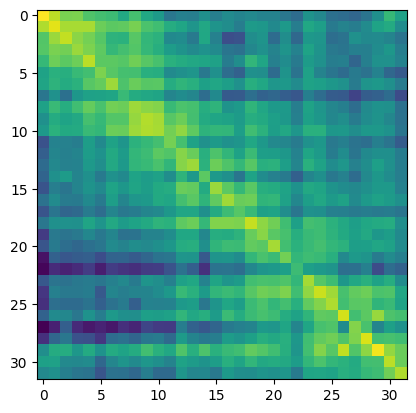

In [146]:
plt.figure()
plt.imshow(EVRs.mean(2))

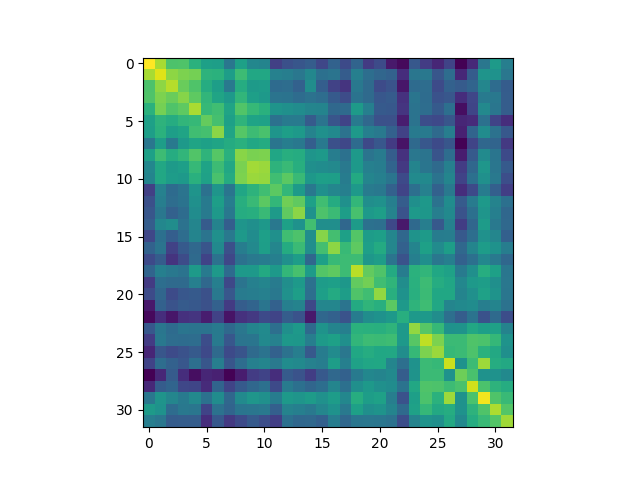

In [147]:
%matplotlib widget

plt.figure()
plt.imshow(EVRs_symm.mean(2))

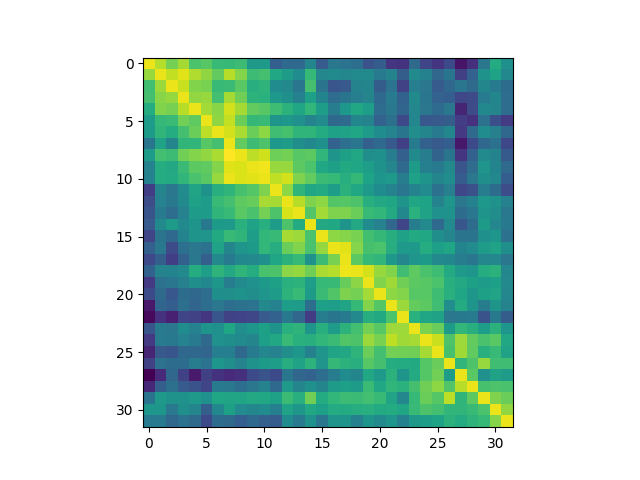

In [148]:
%matplotlib widget

plt.figure()
plt.imshow(EVRs_symm.mean(2) / EVRs_symm.mean(2).diagonal(offset=0)[None,:])

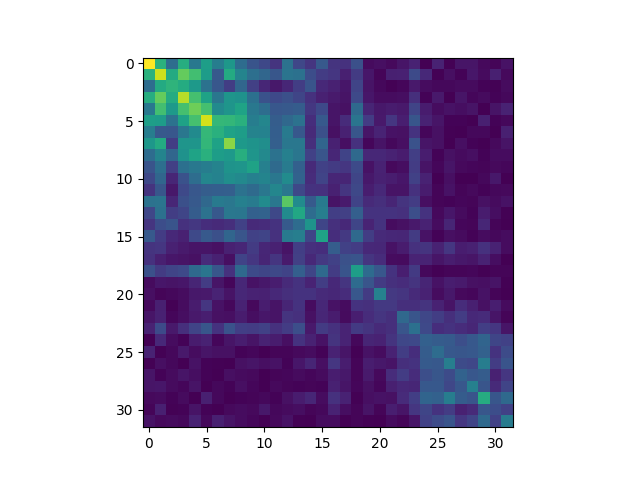

In [173]:
%matplotlib widget

plt.figure()
plt.imshow(EVRs_symm[:,:,4])

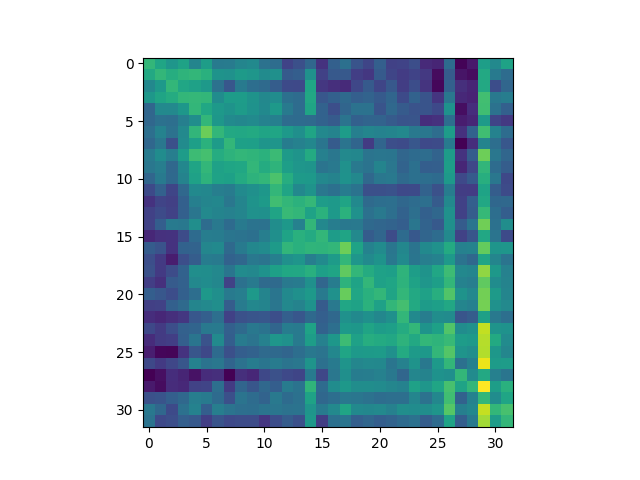

In [150]:
%matplotlib widget

idx = 0

plt.figure()
plt.imshow(EVRs_symm[:,:,idx] / EVRs_symm[:,:,idx].diagonal(offset=0)[None,:])

In [151]:
EVRs_norm = EVRs_symm / EVRs_symm.diagonal(offset=0).T[:,None]

In [152]:
EVRs_norm[range(EVRs_norm.shape[0]), range(EVRs_norm.shape[0]), :] = 0

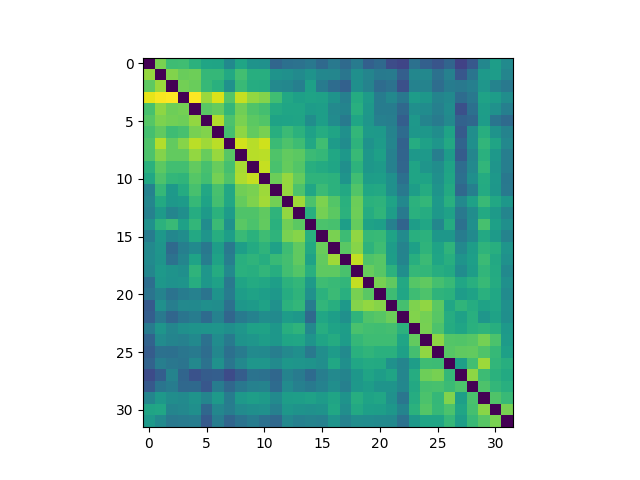

In [153]:
plt.figure()
plt.imshow(EVRs_norm.mean(2))

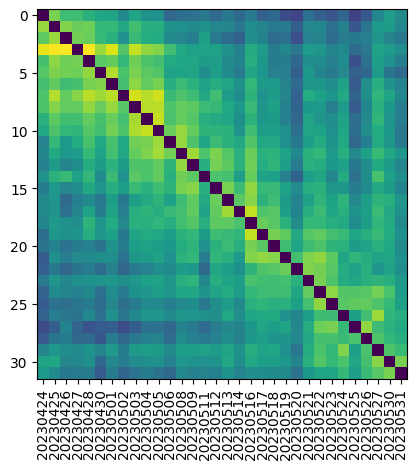

In [166]:
%matplotlib inline
plt.figure()
plt.imshow(EVRs_norm.mean(2))
plt.xticks(np.arange(EVRs_norm.shape[0]), labels=models.keys(), rotation=90);

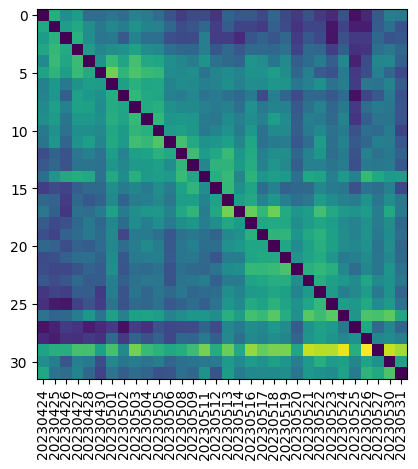

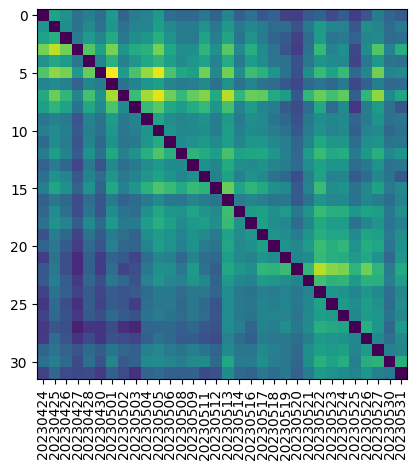

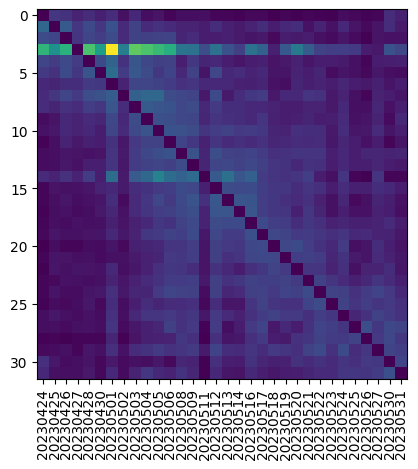

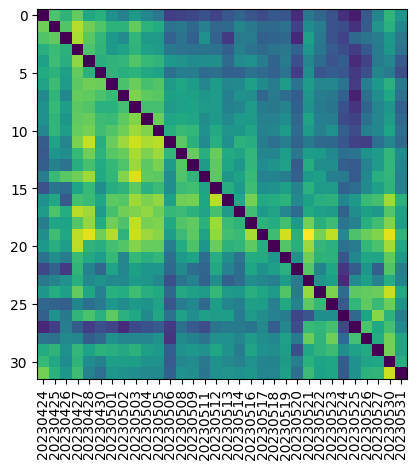

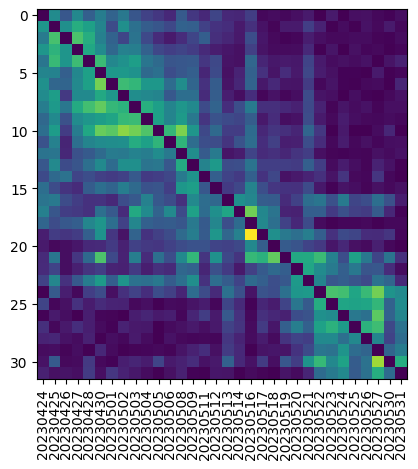

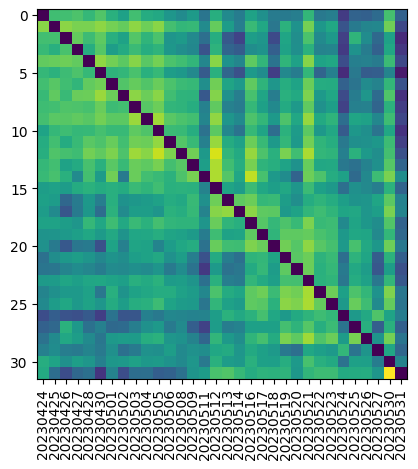

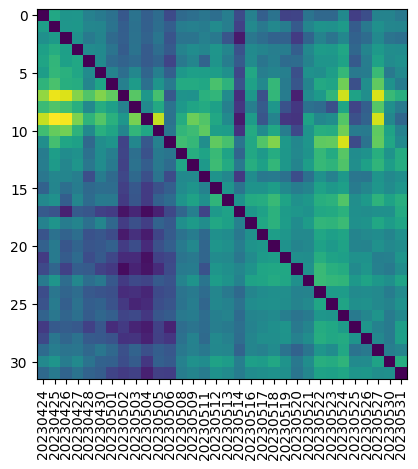

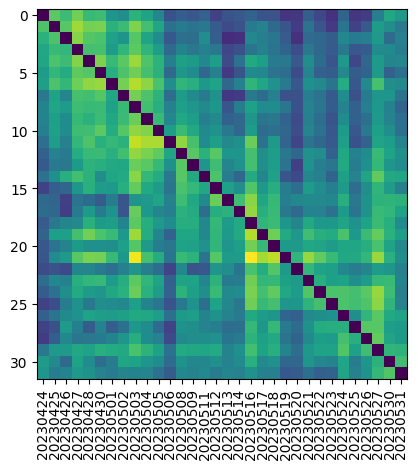

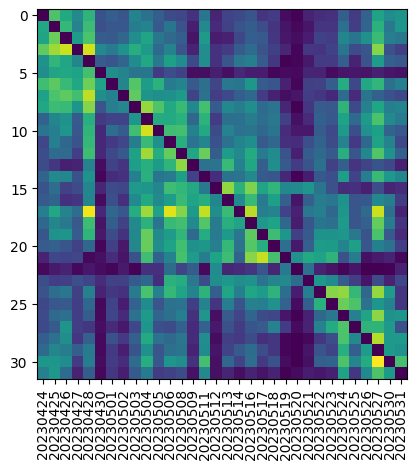

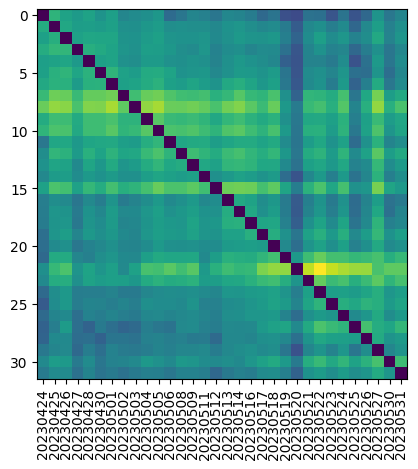

In [176]:
%matplotlib inline

for ii in range(EVRs_norm.shape[2]):
    plt.figure()
    plt.imshow(EVRs_norm[:,:,ii])
    plt.xticks(np.arange(EVRs_norm.shape[0]), labels=models.keys(), rotation=90);

In [155]:
normalizer_2d = np.logical_not(np.eye(EVRs_norm.shape[0]))

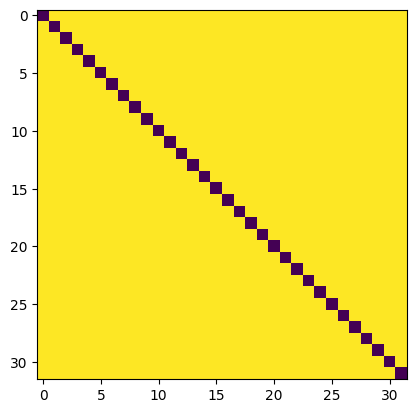

In [156]:
plt.figure()
plt.imshow(normalizer_2d)

In [157]:
import scipy.signal

In [158]:
gaus_2d = bnpm.featurization.gaussian_kernel_2D(
    image_size=(11,11),
    sig=1.5,
)
gaus_2d = gaus_2d / gaus_2d.sum()
    

In [159]:
EVRs_norm_conv = np.stack([scipy.signal.convolve2d(e, gaus_2d, mode='same', boundary='symm') for e in EVRs_norm.transpose(2,0,1)], axis=-1)

In [160]:
normalizer_conv = scipy.signal.convolve2d(normalizer_2d, gaus_2d, mode='same', boundary='symm')

In [161]:
normalizer_conv.shape

(32, 32)

In [162]:
EVRs_norm_conv_normd = EVRs_norm_conv / normalizer_conv[:,:,None]

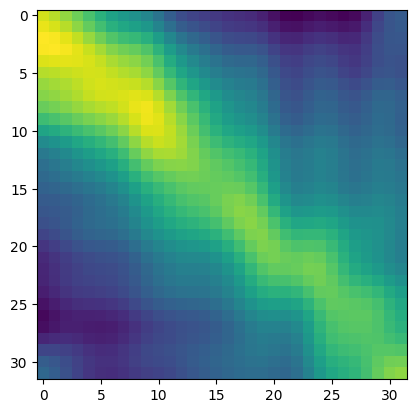

In [163]:
plt.figure()
plt.imshow(EVRs_norm_conv_normd.mean(2), clim=[None,None])

Text(0.5, 1.0, 'similarity to session j. mean of factors')

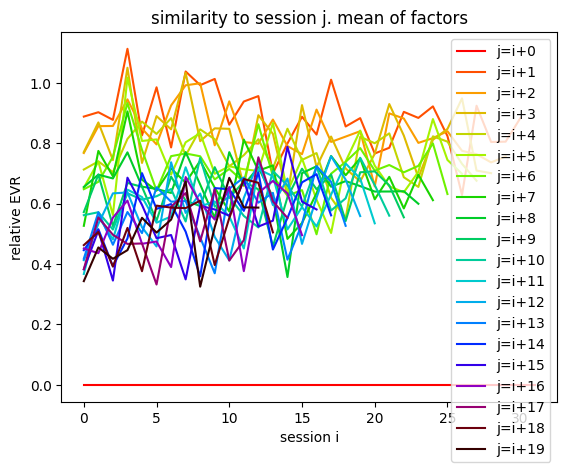

In [165]:
offsets_diag = np.arange(0,20,1, dtype=np.int64)
colors = bnpm.plotting_helpers.simple_cmap(
    colors=[[1, 0, 0], [1, 0.6, 0], [0.8, 0.8, 0], [0.6, 1, 0], [0, 0.8, 0], [0, 0.8, 0.4], [0, 0.8, 0.8], [0, 0.6, 1], [0, 0, 1], [0.7, 0, 0.7], [0.4, 0, 0], [0, 0, 0]],
)

def plot_cross_similarity(EVRs, offsets_diag, colors):
    n_diag = len(offsets_diag)
    plt.figure()
    for ii in range(n_diag):
        plt.plot(
            np.diagonal(EVRs, offset=offsets_diag[ii]), color=colors(ii/n_diag),
            # np.diagonal(EVRs_norm.mean(2), offset=offsets_diag[ii]), color=colors(ii/n_diag),
        )
    plt.xlabel('session i')
    plt.ylabel('relative EVR')
    plt.legend([f'j=i+{n}' for n in offsets_diag])

%matplotlib inline
# plot_cross_similarity(EVRs_norm_conv_normd.mean(2), offsets_diag, colors)
plot_cross_similarity(EVRs_norm.mean(2), offsets_diag, colors)
plt.title(f'similarity to session j. mean of factors')

# for jj in range(EVRs_norm_conv_normd.shape[2]):
#     plot_cross_similarity(EVRs_norm[:,:,jj], offsets_diag, colors)
#     plt.title(f'similarity to session j. factor: {jj}')
    

In [167]:
bin_size = 5

EVRs_norm_triu = np.stack([np.triu(t) for t in EVRs_norm.transpose(2,0,1)], axis=-1)
EVRs_norm_triu[EVRs_norm_triu==0] = np.nan

EVRs_norm_binned = bnpm.image_processing.bin_array(
    array=EVRs_norm_triu, 
    bin_widths=[bin_size,1,1],
    method='append',
    function=np.nanmean,
)

/media/rich/Home_Linux_partition/github_repos/basic_neural_processing_modules/bnpm/image_processing.py:1272: RuntimeWarning: Mean of empty slice
  arr_out = function(arr_out, axis=n, **function_kwargs)


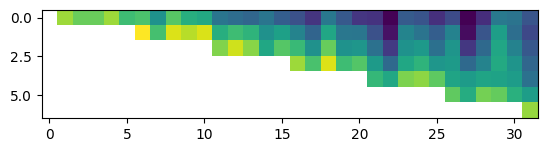

In [179]:
plt.figure()
plt.imshow(EVRs_norm_binned.mean(2))

In [168]:
out = [np.stack([t[bin_size*ii:] for t in temp.T], axis=0) for ii, temp in enumerate(EVRs_norm_binned)]

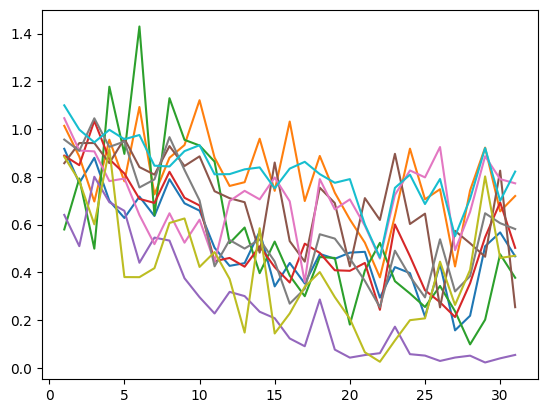

In [169]:
plt.figure()
plt.plot(out[0].T);

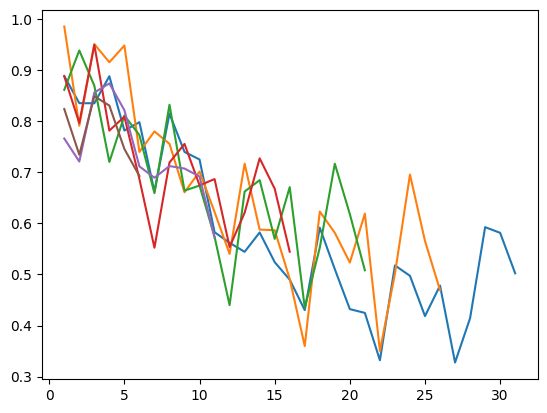

In [170]:
plt.figure()
[plt.plot(o.mean(0)[:]) for o in out];

(0.0, 1.0)

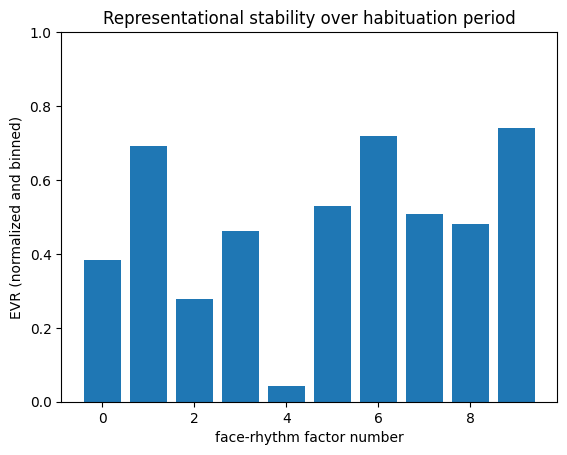

In [171]:
plt.figure()
plt.bar(np.arange(rank), out[0][:,-5:].mean(1))
plt.xlabel('face-rhythm factor number')
plt.ylabel('EVR (normalized and binned)')
plt.title('Representational stability over habituation period')
plt.ylim([0,1])

(0.0, 1.0)

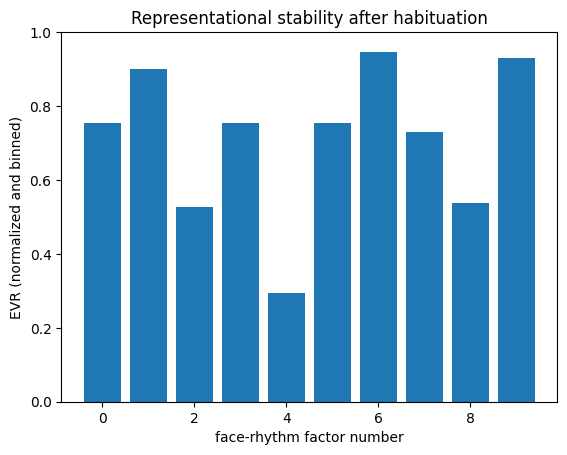

In [180]:
plt.figure()
plt.bar(np.arange(rank), np.nanmean(out[3], axis=1))
plt.xlabel('face-rhythm factor number')
plt.ylabel('EVR (normalized and binned)')
plt.title('Representational stability after habituation')
plt.ylim([0,1])